In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

import jax
from dataclasses import dataclass
import jax.numpy as jnp
import jax.random as jr

import tensorflow_probability.substrates.jax.bijectors as tfb

#with install_import_hook("gpjax", "beartype.beartype"):
import gpjax as gpx
from gpjax.distributions import GaussianDistribution
import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]

key = jr.PRNGKey(123)

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from gpjax.kernels.base import AdditiveKernel


import optax as ox
import tensorflow_probability.substrates.jax.bijectors as tfb



from typing import List, Union, Callable
from jaxtyping import Num, Float
from gpjax.typing import Array, ScalarFloat
from beartype.typing import Optional
from gpjax.base import Module, param_field,static_field
import cola
from cola.linalg.decompositions.decompositions import Cholesky
from jax import vmap
from scipy.stats import qmc

from utils import optim_builder



In [ ]:
# INDUCING POINTS FOR EACH DIM?


100_000 entries sampled across time/lat/lon over first day of data
X2D has:

0"Sea surface temperature (K)"

1"Sensible heat flux (W/m^2)"

2"Latent heat flux (W/m^2)"

3"Vertically-integrated moisture convergence (kg/m^2)"

4"Column relative humidity (%)"

X3D has:

0"Absolute temperature (K)"

1"Relative humidity (%)"

2"Specific humidity (kg/kg)"

3"Geopotential height (m^2 s^-2)"

4"Zonal wind (m/s)"

5"Meridional wind (m/s)"

6"Potential temperature (K)"

7"Equivalent potential temperature (K)"

8"Equivalent potential temperature saturation deficit (K)"

9"Saturated equivalent potential temperature (K)"

10"MSE-conserving plume buoyancy (m/s^2)"

static has:

0"Land-sea mask"

1"Angle of sub-gridscale orography (rad)

2"Anisotropy of sub-gridscale orography"

3"Standard deviation of sub-gridscale orography"

4"Slope of sub-gridscale orography"

Y has:

0"ERA5 Precipitation (mm/hr)"

1"TRMM Precipitation (mm/hr)"

2"TRMM Relative Error (%)"

plev are

1000., 2000., 3000., 5000., 7000., 10000., 15000., 20000., 25000., 30000., 40000., 50000., 60000., 70000.,80000., 85000., 90000., 92500., 95000., 97500., 100000.

In [29]:
from utils import ProblemInfo



def prep_data(type=str, 
              idx_3d:List[int] = [1,4,5,6,7,8,9],
              idx_static:List[int] = [0, 3],
              idx_2d:List[int] = [1,2],):
    #load data
    # X2d_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/X2d_sample.npy"), dtype=jnp.float64) # [N, D] Fiddled
    # X3d_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/X3d_sample.npy"), dtype=jnp.float64) # [N, D]
    # Xstatic_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/XStatic_sample.npy"), dtype=jnp.float64) # [N, D]
    # Y_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/Y_sample.npy"), dtype=jnp.float64) # [N, 1]
    X2d_raw = jnp.array(jnp.load("../data/100_000_one_day/X2D_sample.npy"), dtype=jnp.float64) # [N, D]
    X3d_raw = jnp.array(jnp.load("../data/100_000_one_day/X3D_sample.npy"), dtype=jnp.float64) # [N, D]
    Xstatic_raw = jnp.array(jnp.load("../data/100_000_one_day/XSTATIC_sample.npy"), dtype=jnp.float64) # [N, D]
    Y_raw = jnp.array(jnp.load("../data/100_000_one_day/Y_sample.npy"), dtype=jnp.float64) # [N, 1]


    pressure = jnp.array([[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,60000,70000,80000, 85000,90000,92500,95000,97500,100000]], dtype=jnp.float64)
    # random shuffle
    X2d = jr.permutation(key, X2d_raw)
    X3d = jr.permutation(key, X3d_raw)
    Xstatic = jr.permutation(key, Xstatic_raw)
    Y = jr.permutation(key, Y_raw)

    # look at ERA5 rain
    Y = Y[:,0:1] 

    # just keep the "prognostic" 3d inputs that joe considered (for now)
    # RH, tehta_e^+, theta_e, theta_e^*
    names_3d =  ["Absolute temperature,","Relative Humidity", "Specific Humidity", "Geopotential Height", "Zonal Wind","Meridional Wind","Potential Temperature (theta)","Equivalent Potential Temperature (tehta_e)", "Equivalent Potential Temperature Saturation Deficit (theta_e+)", "Saturated Equivalent Potential Temperature (theta_e*)", "MSE-conserving Plume Buoyancy"]
    names_3d_short =  ["K,","RH", "q", "gh", "wind_z","wind_m","theta","tehta_e", "theta_e+", "theta_e*", "plume"]
    # idx_3d = [1, 7, 8, 9]
    names_3d = [names_3d[i] for i in idx_3d]
    names_3d_short = [names_3d_short[i] for i in idx_3d]
    X3d = X3d[:,idx_3d,:]
    

    names_static = ["Land-sea Mask","Angle of sub-gridscale orography","Anisotropy of sub-gridscale orography","Stdev of sub-gridscale orography","Slope of sub-gridscale orography"]
    names_static_short = ["LSM","O_angle","O_anisotrophy","O_sd","O_slope"]
    names_static = [names_static[i] for i in idx_static]
    names_static_short = [names_static_short[i] for i in idx_static]
    Xstatic = Xstatic[:,idx_static]
    lsm_threshold = 0.5
    # # also use his "normalisatopm" for sigma_o
    # try:
    #     o_sd_idx = names_static.index("Stdev of sub-gridscale orography")
    #     lsm_idx = names_static.index("Land-sea Mask")
    #     #Xstatic = Xstatic.at[:, o_sd_idx].set(jnp.where(Xstatic[:,lsm_idx]<lsm_threshold, jnp.nanmean(1.0+jnp.log(1+Xstatic[:,o_sd_idx][Xstatic[:,lsm_idx]>lsm_threshold])), 1.0+jnp.log(1+Xstatic[:,o_sd_idx]))) # optimize lsm_threshold?
    #     Xstatic = Xstatic.at[:, o_sd_idx].set(jnp.log(Xstatic[:,o_sd_idx]+1.0))
    #     #map = lambda x: jnp.log((x+1e-5)/(1-x+1e-5))
    #     # Xstatic = Xstatic.at[:,lsm_idx].set(map(Xstatic[:,lsm_idx]))
    #     # lsm_threshold = map(lsm_threshold)
    # except:
    #     pass



    # names_2d = ["Sea Surface temperature", "Sensible heat flux land","Sensible heat flux sea", "Latent heat flux land","Latent heat flux sea", "Vertically-integrated moisture convergence", "Column relative humidity"]
    # names_2d_short = ["T_surface","flux_s_land","flux_s_sea","flux_l_land","flux_l_sea","moisture","CRH"]
    names_2d = ["Sea Surface temperature", "Sensible heat flux", "Latent heat flux", "Vertically-integrated moisture convergence", "Column relative humidity"]
    names_2d_short = ["T_surface","flux_s","flux_l","moisture","CRH"]
    names_2d = [names_2d[i] for i in idx_2d]
    names_2d_short = [names_2d_short[i] for i in idx_2d]
    X2d = X2d[:,idx_2d]
    #sea_surface_idx = names_2d.index("Sea Surface temperature")
    # sea_surface = jnp.where(Xstatic[:,lsm_idx]>lsm_threshold, jnp.nanmean(X2d[:,sea_surface_idx]), X2d[:, sea_surface_idx])
    # X2d = X2d.at[:,sea_surface_idx].set(sea_surface) # turn nans corresonping to land for sea surface to fixed value, they will be ignored by switch kernels anyway 
    # flux_s_idx = names_2d.index("Sensible heat flux")
    # flux_l_idx = names_2d.index("Latent heat flux")
    #X2d = X2d.at[:,flux_s_idx].set(jnp.log(X2d[:,flux_s_idx]+0.01 - jnp.min(X2d[:,flux_s_idx])) )
    # X2d = X2d.at[:,flux_l_idx].set(jnp.log(X2d[:,flux_l_idx]+1.0 - jnp.min(X2d[:,flux_l_idx])))

    #remove all pressure levels above 500 hPA
    lowest_idx =  11# 7 
    print(f"Removed all pressure levels below {pressure[:,lowest_idx]} hPa")
    X3d = X3d[:, :, lowest_idx:]
    pressure_levels = pressure[:,lowest_idx:]
    pressure_mean = jnp.mean(pressure_levels)
    pressure_std = jnp.std(pressure_levels)
    pressure_levels = (pressure_levels - pressure_mean) / pressure_std

    # remove any entries with nan
    X3d_nan_idx = jnp.isnan(X3d).any(axis=1).any(axis=1)
    X2d_nan_idx = jnp.isnan(X2d).any(axis=1) # ignore sea surface
    Xstatic_nan_idx = jnp.isnan(Xstatic).any(axis=1)
    Y_nan_idx = jnp.isnan(Y).any(axis=1)
    any_nan = X3d_nan_idx | X2d_nan_idx | Y_nan_idx | Xstatic_nan_idx
    no_nan = ~ any_nan
    print(f"Removed {any_nan.sum()} entries with nan")
    X2d = X2d[no_nan,:]
    X3d = X3d[no_nan,:,:]
    Xstatic = Xstatic[no_nan,:]
    Y = Y[no_nan,:]



    if type == "no rain":
        # remove no rain days
        print(f"Removed {(Y[:,0]==0).sum()} entries with zero rain")
        X3d = X3d[Y[:,0]>0,:]
        X2d = X2d[Y[:,0]>0,:]
        Xstatic = Xstatic[Y[:,0]>0,:]
        Y = Y[Y[:,0]>0,:]
    elif type == "just rain":
        # convert output to binary 
        Y = jnp.where(Y>0, 1.0, 0.0)
    elif type == "all":
        pass   
    else:
        raise ValueError("type must be 'no rain' or 'just rain'")


    num_2d_variables= X2d.shape[1]
    num_3d_variables= X3d.shape[1]
    num_static_variables= Xstatic.shape[1]
    num_variables = num_2d_variables + num_3d_variables + num_static_variables
    print(f"using {num_static_variables} static variables")
    print(f"using {num_2d_variables} 2d variables")
    print(f"using {num_3d_variables} 3d variables")
    names = names_3d + names_2d + names_static
    names_short = names_3d_short + names_2d_short + names_static_short
    print(f"using variables with names {names_short}")




    X3d = jnp.mean((X3d-jnp.mean(X3d,0, keepdims=True))/jnp.std(X3d,0, keepdims=True),-1)
    X = jnp.hstack([X3d, X2d, Xstatic])
    #X = (X-jnp.min(X,0))/(jnp.max(X,0)-jnp.min(X,0))
    X = (X-jnp.mean(X,0, keepdims=True))/(jnp.std(X,0, keepdims=True))


    # Y = Y+1e-5
    # Y = jnp.log(Y+1e-5)
    # print(f"WARNING WE logged Y") # TODO

    Y = Y/jnp.std(Y)
    print(f"WARNING WE standardfized Y") # TODO

    D = gpx.Dataset(X=X, y= Y)


    problem_info = ProblemInfo(
        num_2d_variables = num_2d_variables,
        num_3d_variables = num_3d_variables,
        num_static_variables = num_static_variables,
        names_2d_short = names_2d_short,
        names_3d_short = names_3d_short,
        names_static_short = names_static_short,
        names_2d = names_2d,
        names_3d = names_3d,
        names =names,
        names_short = names_short,
        names_static = names_static,
        num_variables = num_variables,
        pressure_levels = pressure_levels,
        pressure_mean = pressure_mean,
        pressure_std = pressure_std,
        lsm_threshold = lsm_threshold,
    )



    return D, problem_info
    

    

In [30]:

@dataclass
class Normalizer(Module):
    x: Float[Array, "N D"] = static_field(None)
    sinharcsinh_skewness: Float[Array, " D"] = param_field(jnp.array([0.0]))
    sinharcsinh_tailweight: Float[Array, " D"] = param_field(jnp.array([1.0]), bijector=tfb.Softplus(low=jnp.array(1e-5, dtype=jnp.float64)))
    standardizer_scale: Float[Array, " D"] = param_field(jnp.array([1.0]), bijector=tfb.Softplus(low=jnp.array(1e-5, dtype=jnp.float64)))
    standardizer_shift: Float[Array, " D"] = param_field(jnp.array([0.0]))
        
    """
    :param x: input to transform
    :param log: whether to log x first before applying flows of transformations
    :return: flows of transformations to match x to standard Gaussian
    """

    def get_bijector(self):
        return tfb.Chain([
            tfb.SinhArcsinh(
                skewness=self.sinharcsinh_skewness,
                tailweight=self.sinharcsinh_tailweight,
            ),
            tfb.Scale(
                scale=self.standardizer_scale,
            ),
            tfb.Shift(
                shift=self.standardizer_shift,
            ),
        ])


    def loss_fn(self, negative=False, log_prior: Optional[Callable] = None)->gpx.objectives.AbstractObjective:
        class KL(gpx.objectives.AbstractObjective):
            def step(
                self,
                posterior: Normalizer,
                train_data: gpx.Dataset,
            ) -> ScalarFloat:
                bij = posterior.get_bijector()
                return self.constant * (
                    jnp.mean((0.5 * jnp.square(bij(posterior.x))))
                    - jnp.mean(bij.forward_log_det_jacobian(posterior.x,event_ndims=0)))
        return KL(negative=negative)


def fit_normaliser(data, num_transforms):
    d = jnp.shape(data)[1]
    for i in range(num_transforms):
        normaliser = Normalizer(x=data, sinharcsinh_skewness=jnp.array([0.0]*d), sinharcsinh_tailweight=jnp.array([1.0]*d), standardizer_scale=jnp.array([1.0/jnp.std(data,0)]), standardizer_shift=jnp.array([-jnp.mean(data,0)]))
        opt_normaliser, history = gpx.fit_scipy(model = normaliser, objective = normaliser.loss_fn(negative=False), train_data = None, safe=False)
        data = opt_normaliser.get_bijector()(data)
    return data



Removed all pressure levels below [50000.] hPa
Removed 28 entries with nan
using 2 static variables
using 2 2d variables
using 7 3d variables
using variables with names ['RH', 'wind_z', 'wind_m', 'theta', 'tehta_e', 'theta_e+', 'theta_e*', 'flux_s', 'flux_l', 'LSM', 'O_sd']
WARNING WE standardfized Y
standardizing RH
Optimization terminated successfully.
         Current function value: 0.442751
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.492806
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.500438
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.500007
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 

/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -3.264575
         Iterations: 500
         Function evaluations: 648
         Gradient evaluations: 648
Optimization terminated successfully.
         Current function value: -0.237304
         Iterations: 87
         Function evaluations: 107
         Gradient evaluations: 107
Optimization terminated successfully.
         Current function value: 0.281380
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.519583
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.502752
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
standardizing O_sd
Optimization terminated successfully.
         Current function value: -1.196252
         Iterations: 321
         Function evaluations: 393
         Gra

/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -0.860065
         Iterations: 500
         Function evaluations: 633
         Gradient evaluations: 633
Optimization terminated successfully.
         Current function value: 0.096310
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 0.526148
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.503979
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11


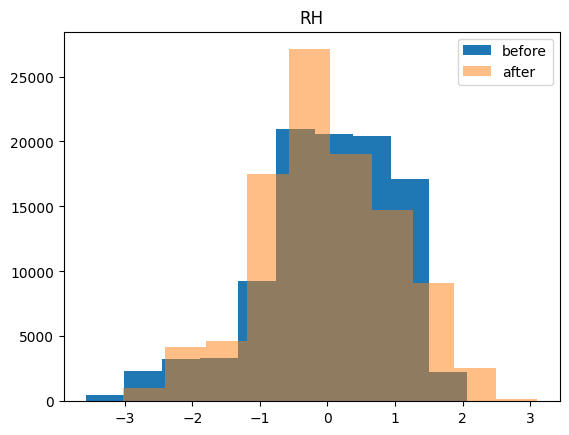

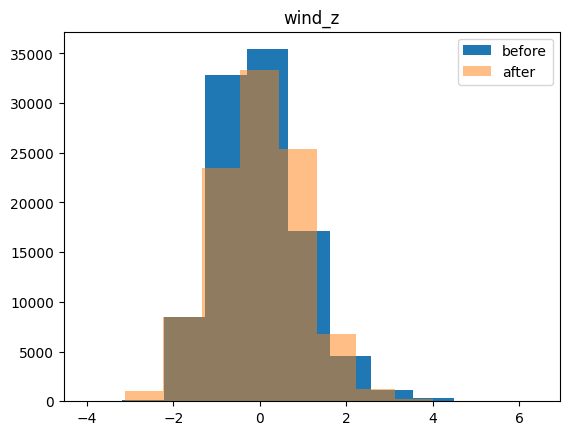

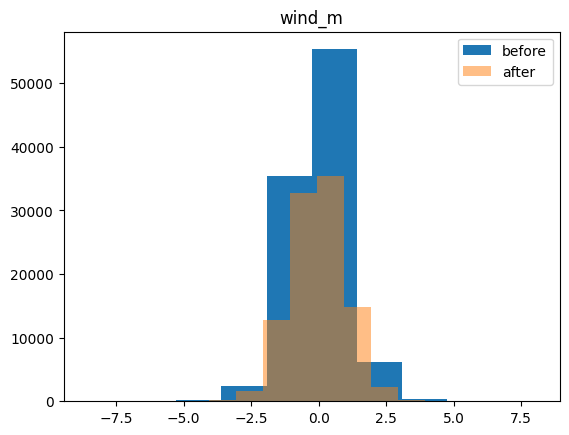

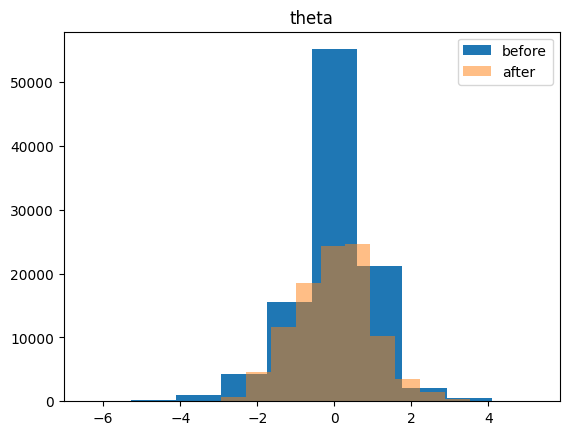

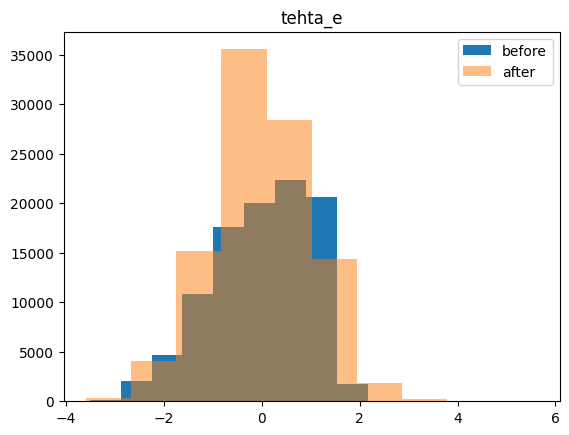

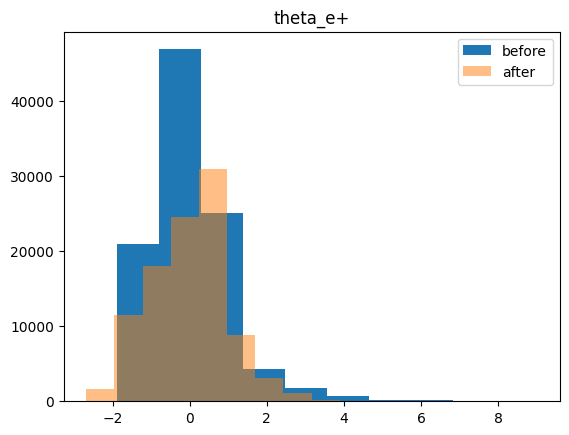

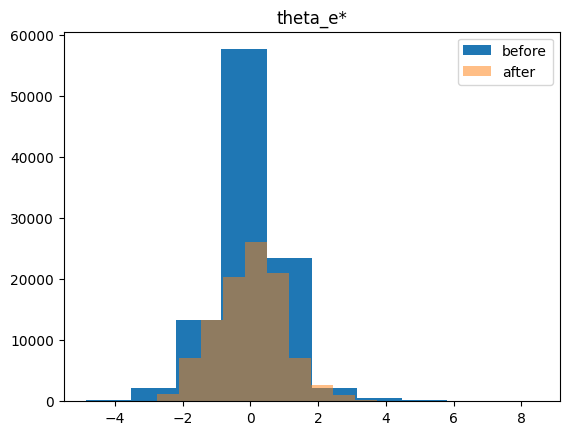

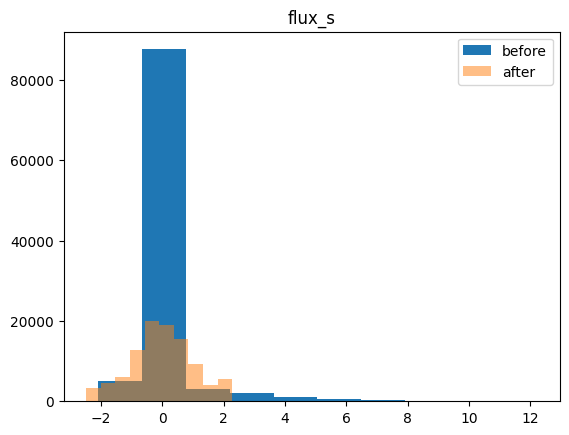

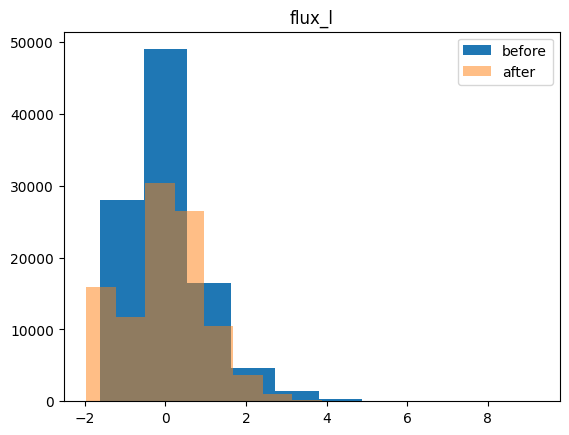

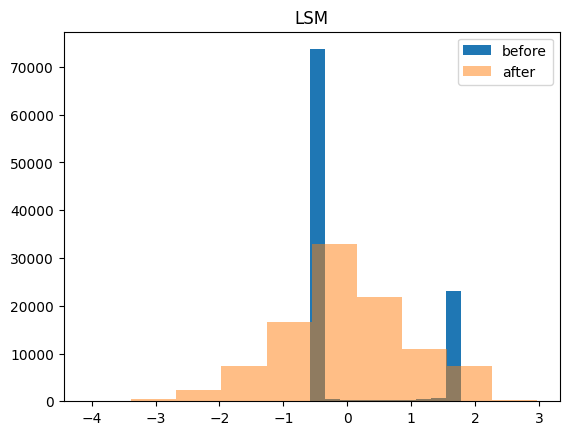

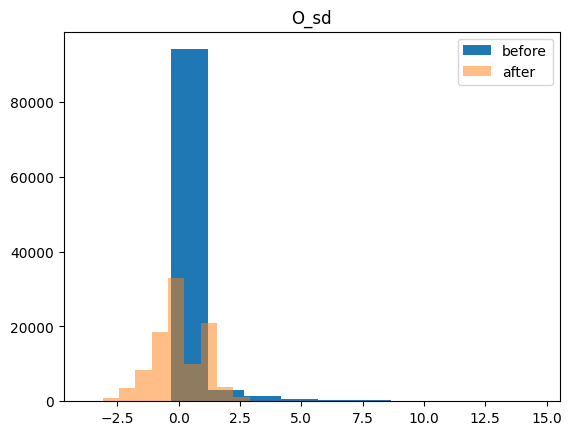

In [25]:
from plotting import plot_data


D, problem_info = prep_data("all")
# plot_data(problem_info,D)


X = D.X
num_transforms = 5

for i, name in enumerate(problem_info.names_short):
    plt.figure()
    print(f"standardizing {name}")
    if name in ["LSM", "O_sd"]:
        X = X.at[:,i:i+1].set((X[:,i:i+1] + 0.001*jr.normal(jr.PRNGKey(1234),(X.shape[0],1))))
    plt.hist(X[:,i], label="before")
    X = X.at[:,i:i+1].set(fit_normaliser(X[:,i:i+1], num_transforms))
    plt.hist(X[:,i], label="after", alpha=0.5)
    plt.legend()
    plt.title(f"{name}")
     
                
D = gpx.Dataset(X=X, y= D.y)

In [37]:
from models import VariationalPrecipGP
from utils import Exponential, Gamma, Gamma2, BernoulliGamma, BernoulliExponential







def fit_model(
    data: gpx.Dataset,
    likelihood, 
    base_kernels, 
    interaction_variances,
    variaitonal_mean,
    variational_root_covariance,
    inducing_points,
    train_inducing_points=False,
    verbose=False,
    seed=1234):
    

    KEY = jr.PRNGKey(seed)

    posterior = VariationalPrecipGP(
        base_kernels=base_kernels,   
        likelihood = likelihood,
        max_interaction_depth=2,
        interaction_variances = interaction_variances,
        num_latents=len(base_kernels),
        measure="Gaussian",
        inducing_inputs=inducing_points, # [N, D]
        variational_mean=variaitonal_mean, # [L, N, 1]
        variational_root_covariance=variational_root_covariance, # [L, N, N]
        parameterisation="whitened",
        use_shared_kernel=False,
        dists={},
    ).replace_bijector(
        #variational_mean = tfb.SoftClip(low=jnp.array(1e-2, dtype=jnp.float64)),  # TODO MAKES EVERYTHING POSITIVE
        interaction_variances = tfb.Softplus(low=jnp.array(1e-5, dtype=jnp.float64)) 
    )
    if not train_inducing_points:
        posterior = posterior.replace_trainable(inducing_inputs=False)
        

    optim_pytree = posterior.replace(
        base_kernels = ox.adam(1e-1), 
        interaction_variances = ox.adam(1e-1),
        likelihood = ox.adam(1e-2),
        variational_mean = ox.adam(1e-2),
        variational_root_covariance = ox.adam(1e-2), 
        inducing_inputs= ox.adam(1e-2),
        )

    optim = optim_builder(optim_pytree)


    opt_posterior, history = gpx.fit(
            model=posterior,
            objective=posterior.loss_fn(negative=True), #todo rejit
            train_data=data,
            optim=optim,
            num_iters=2000,
            # verbose=False
            batch_size=128,
            safe=False,
            key=key,
        )
    plt.plot(history, label=f"model")
    plt.legend()
    print(f"score is {history[-1]}")

    if verbose:
        for j in range(opt_posterior.num_latent):
            for i, name in enumerate(problem_info.names_short):
                if opt_posterior.use_shared_kernel:
                    print(f"latent {j} has {name} with lengthscale {opt_posterior.base_kernels[j][i].lengthscale}")
                else:
                    print(f"latent {j} has {name} with lengthscale {opt_posterior.base_kernels[j][i].lengthscale}")

            print(f"latent {j} has interaction variances are {opt_posterior.interaction_variances[j]}")
    return opt_posterior

In [38]:
num_inducing_points = 25
ip = D.X[:num_inducing_points,:]
fit_from_scratch = False



    
bernoulli_model = fit_model(
    data = gpx.Dataset(D.X, jnp.where(D.y>0, 1.0, 0.0)), # binary data
    likelihood=gpx.likelihoods.Bernoulli(num_datapoints=D.n), 
    base_kernels = [[gpx.kernels.RBF(lengthscale=1.0, active_dims=[i]).replace_trainable(variance=False).replace_bijector(lengthscale=tfb.Softplus(low=jnp.array([0.1], dtype=jnp.float64))) for i in range(problem_info.num_variables)]],
    interaction_variances=jnp.array([[1.0]*(3)], dtype=jnp.float64),
    variaitonal_mean = 0.1*jnp.ones((1, num_inducing_points, 1)),
    variational_root_covariance = jnp.tile(jnp.eye(num_inducing_points)[None,:,:],(1, 1, 1)), # [L, N, N],
    inducing_points=ip,
    train_inducing_points=False,
    )


gamma_model = fit_model(
    data = gpx.Dataset(D.X[D.y[:,0]>0,:], D.y[D.y[:,0]>0,:]), # just rainy days
    likelihood=gpx.likelihoods.Gamma2(num_datapoints=D.n), 
    base_kernels = [[gpx.kernels.RBF(lengthscale=1.0, active_dims=[i]).replace_trainable(variance=False).replace_bijector(lengthscale=tfb.Softplus(low=jnp.array([0.1], dtype=jnp.float64))) for i in range(problem_info.num_variables)] for j in range(2)],
    interaction_variances=jnp.array([[1.0]*(3)]*2, dtype=jnp.float64),
    variaitonal_mean = 0.1*jnp.ones((2, num_inducing_points, 1)),
    variational_root_covariance = jnp.tile(jnp.eye(num_inducing_points)[None,:,:],(2, 1, 1)), # [L, N, N],
    inducing_points=ip,
    train_inducing_points=False,
    )



full_model = fit_model(
    data = gpx.Dataset(D.X[D.y[:,0]>0,:], D.y[D.y[:,0]>0,:]), # just rainy days
    likelihood=gpx.likelihoods.BernoulliGamma(num_datapoints=D.n), 
    base_kernels = [
        bernoulli_model.base_kernels[0],
        gamma_model.base_kernels[0],
        gamma_model.base_kernels[1],
        ],
    interaction_variances= jnp.stack([bernoulli_model.interaction_variances[0], gamma_model.interaction_variances[0], gamma_model.interaction_variances[1]]),
    variaitonal_mean = jnp.stack([bernoulli_model.variational_mean[0], gamma_model.variational_mean[0], gamma_model.variational_mean[1]]),
    variational_root_covariance = jnp.stack([bernoulli_model.variational_root_covariance[0], gamma_model.variational_root_covariance[0], gamma_model.variational_root_covariance[1]]),
    inducing_points=ip,
    train_inducing_points=True,
    )




  0%|          | 0/2000 [00:00<?, ?it/s]

UnboundLocalError: local variable 'i' referenced before assignment

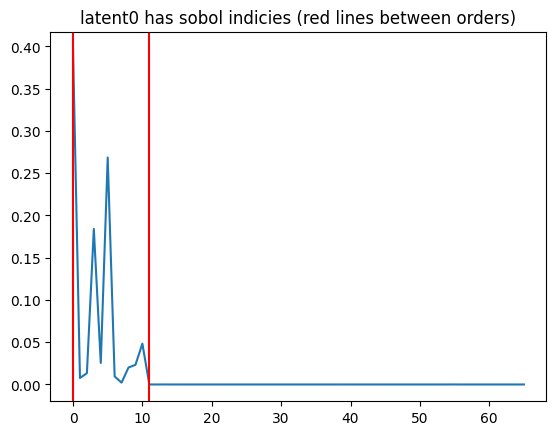

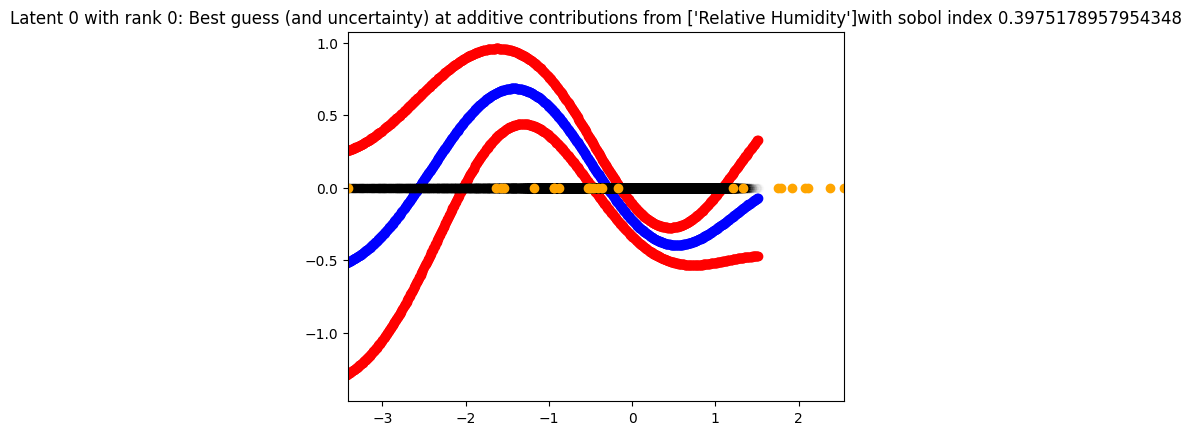

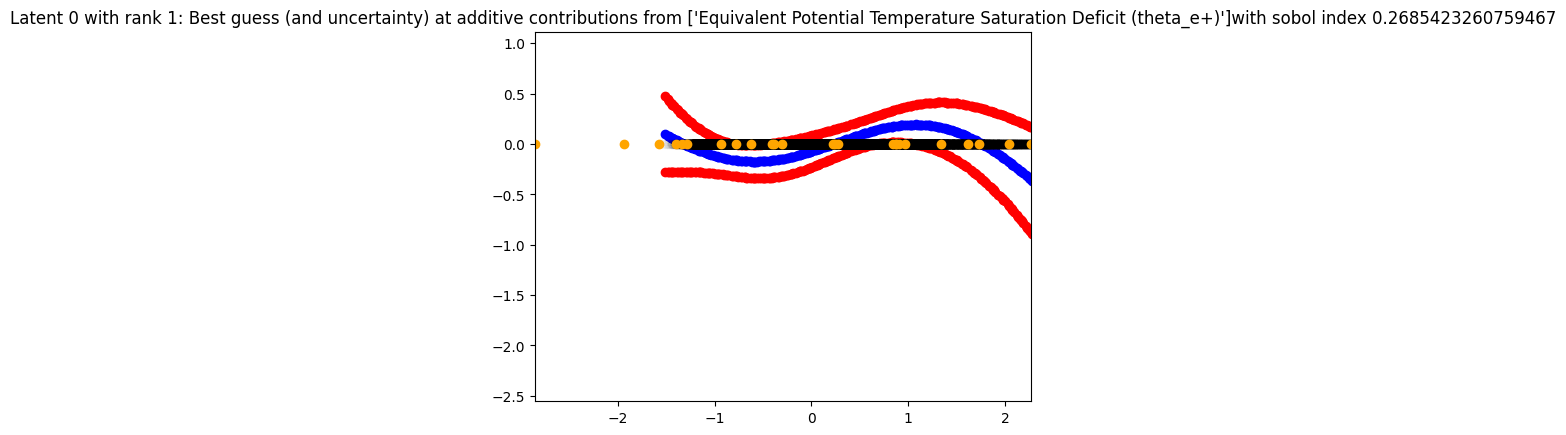

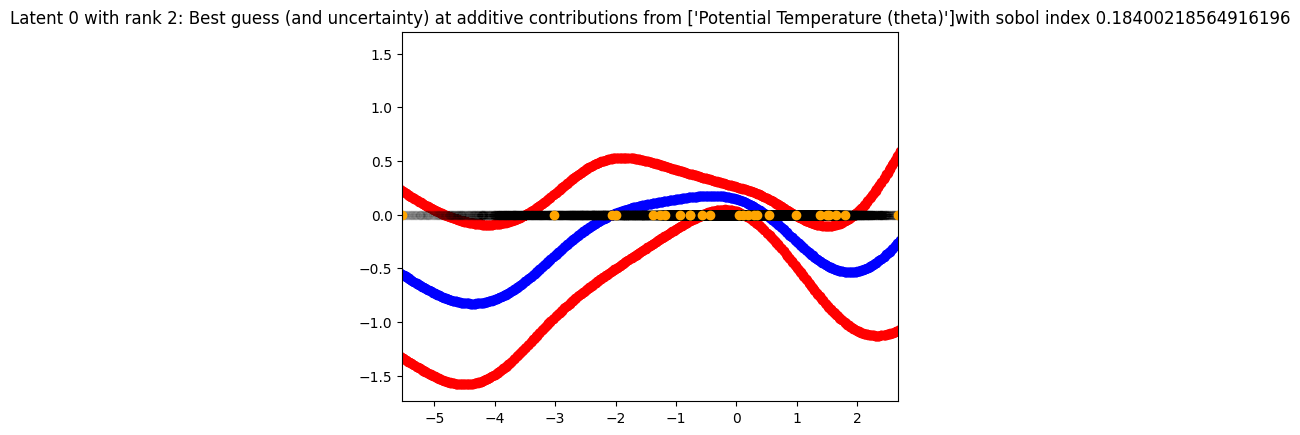

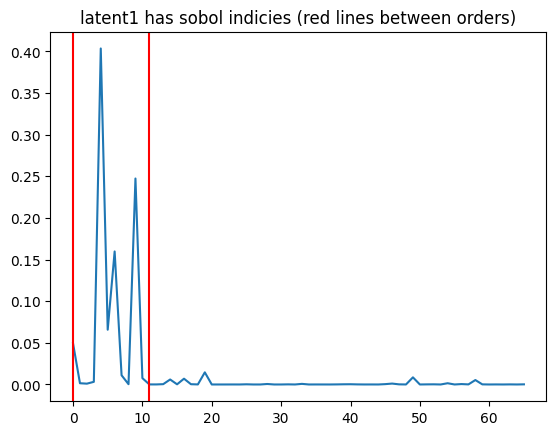

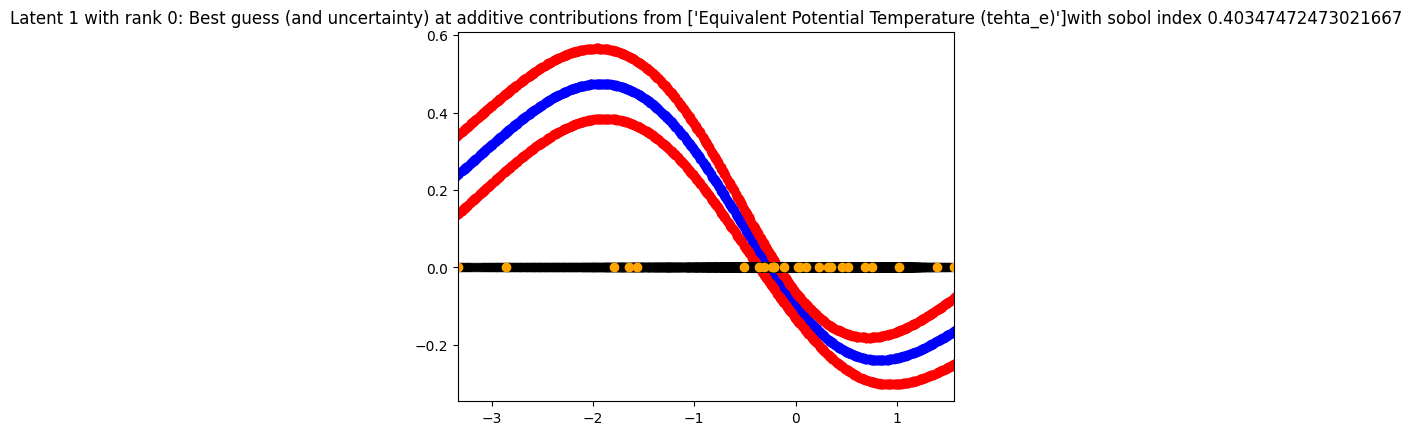

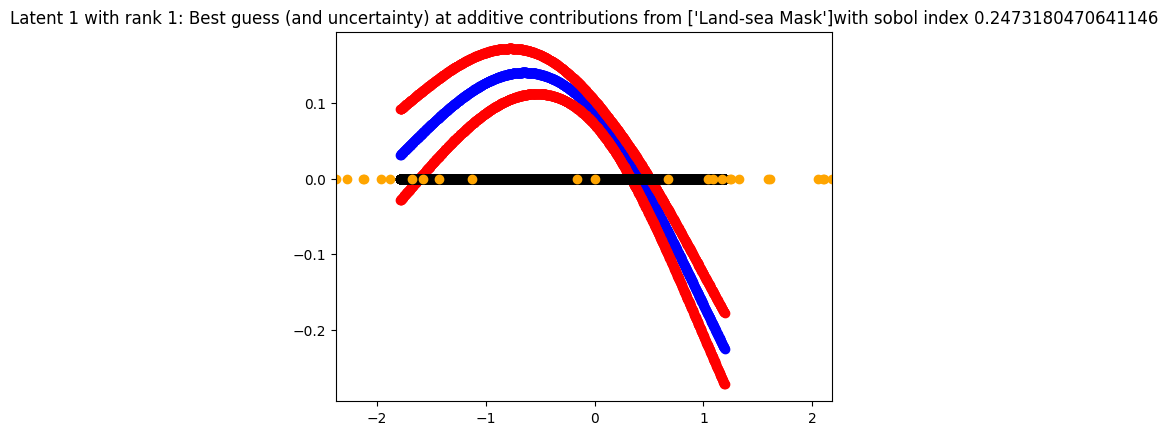

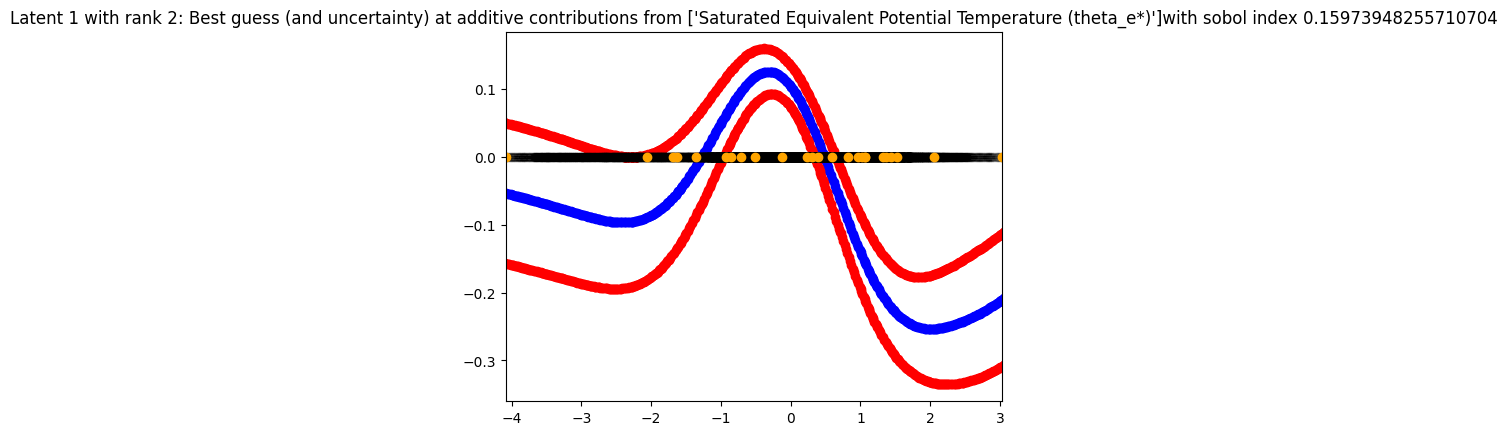

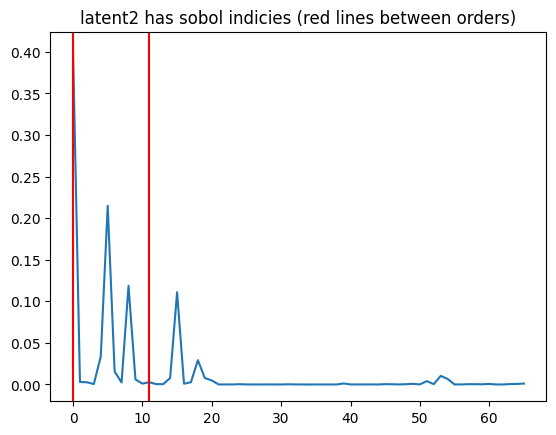

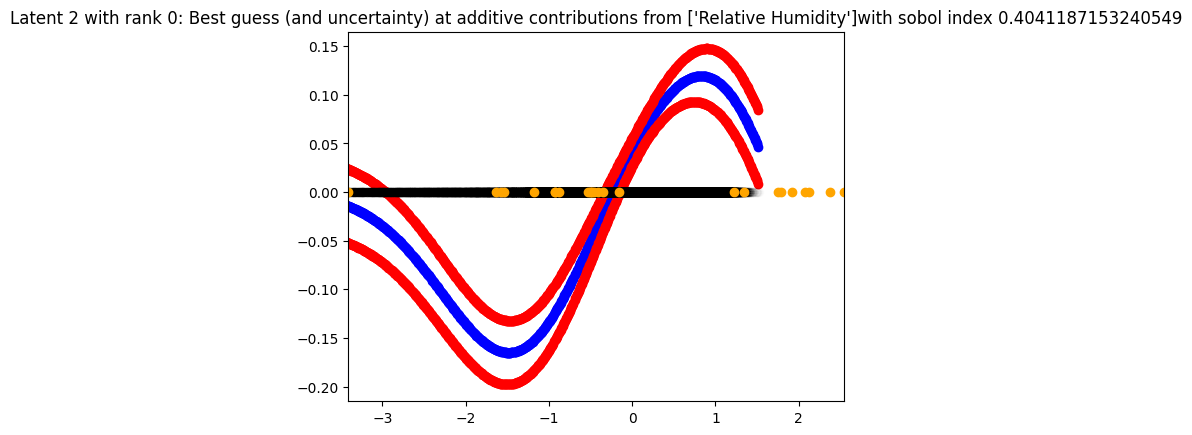

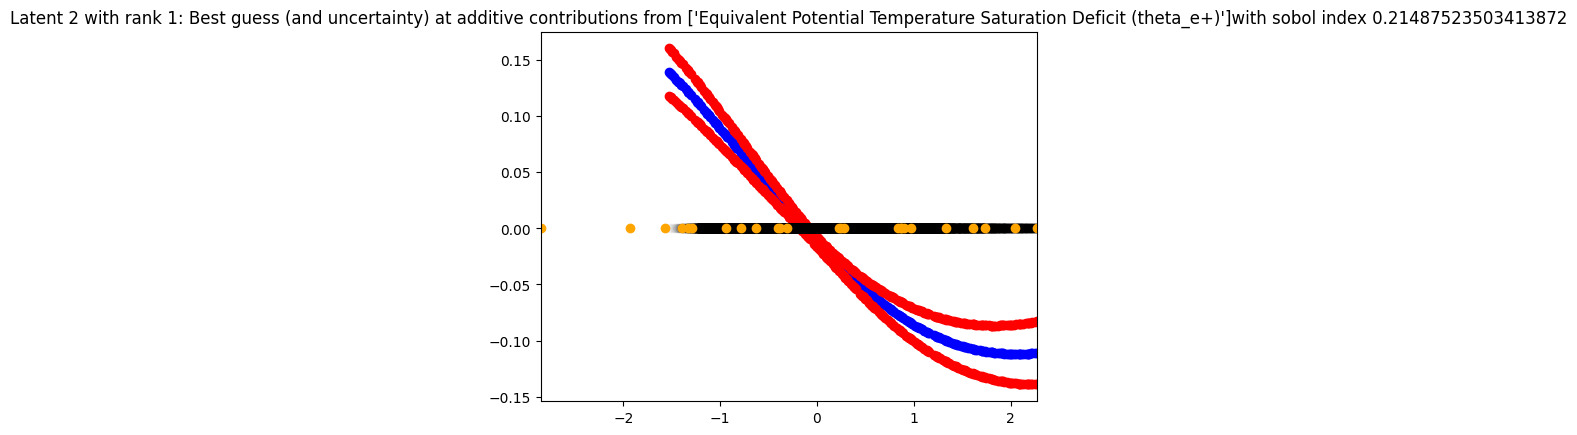

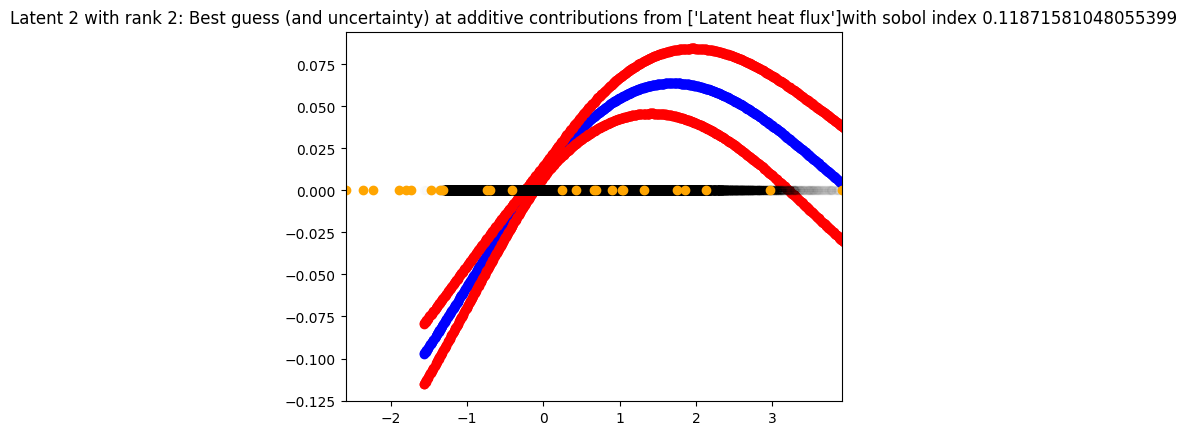

In [32]:
from plotting import plot_interactions
plot_interactions(problem_info, opt_posterior, D, use_range=False, k=3)

In [7]:
# from utils import thin_model

# thinned_model = thin_model(problem_info,D, opt_posterior, 3)


removed theta from latent 0
removed theta from latent 1
removed RH from latent 2
removed wind_m from latent 0
removed flux_l from latent 1
removed theta_e* from latent 2
removed flux_l from latent 0
removed theta_e* from latent 1
removed wind_z from latent 2
removed flux_s from latent 0
removed wind_z from latent 1
removed theta from latent 2
removed tehta_e from latent 0
removed wind_m from latent 1
removed LSM from latent 2
removed theta_e+ from latent 0
removed theta_e+ from latent 1
removed flux_l from latent 2
removed wind_z from latent 0
removed O_sd from latent 1
removed tehta_e from latent 2
removed LSM from latent 0
removed LSM from latent 1
removed wind_m from latent 2


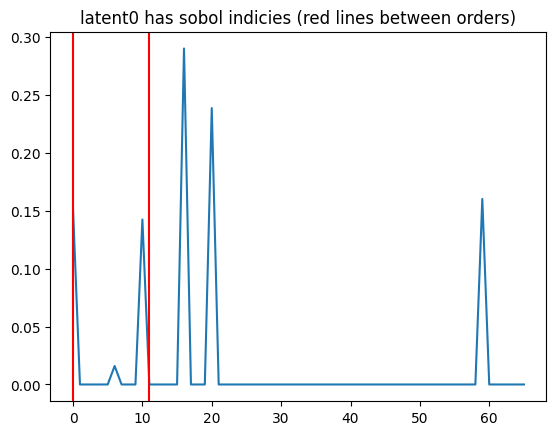

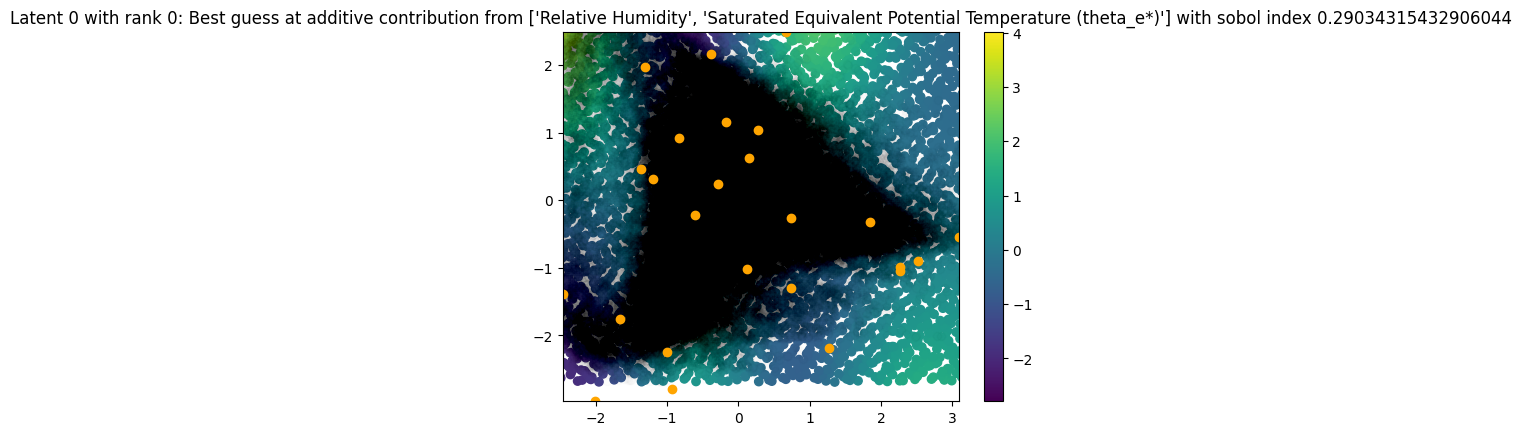

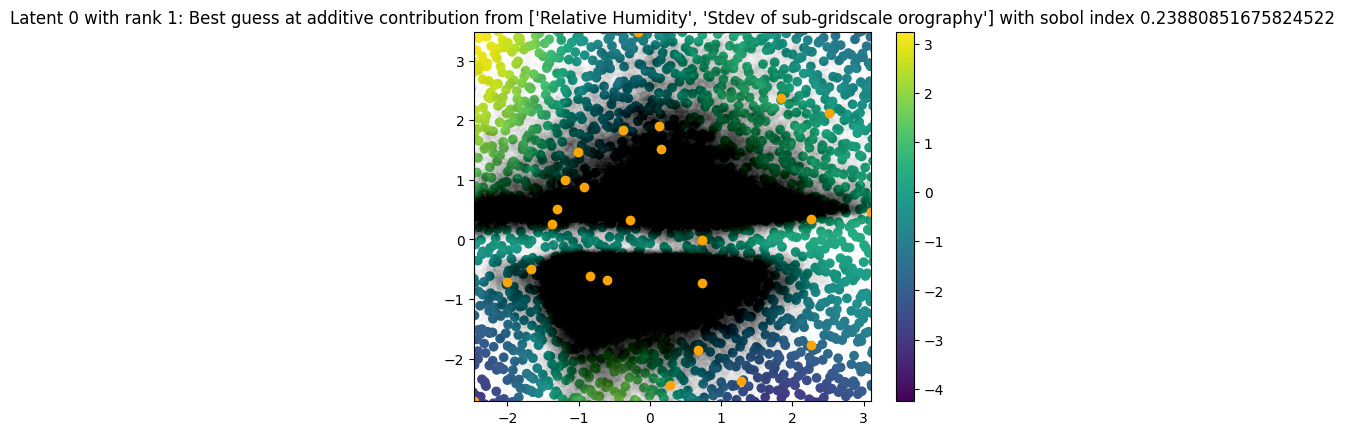

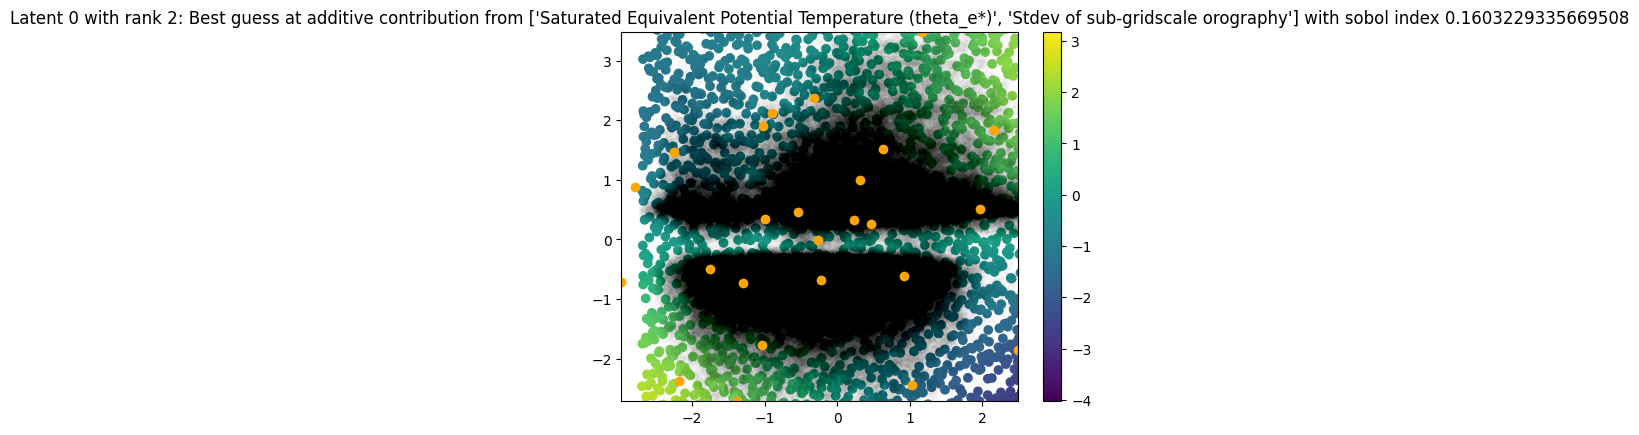

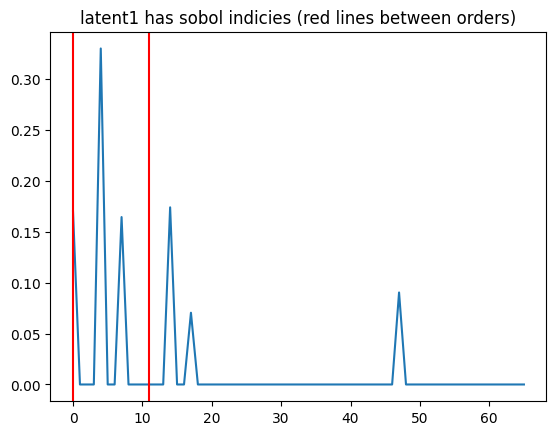

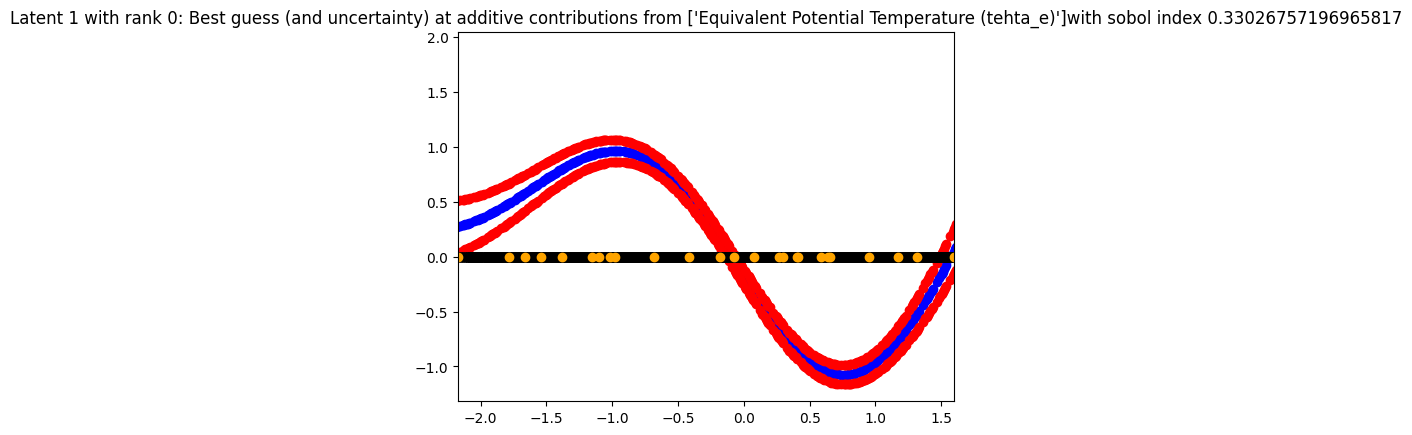

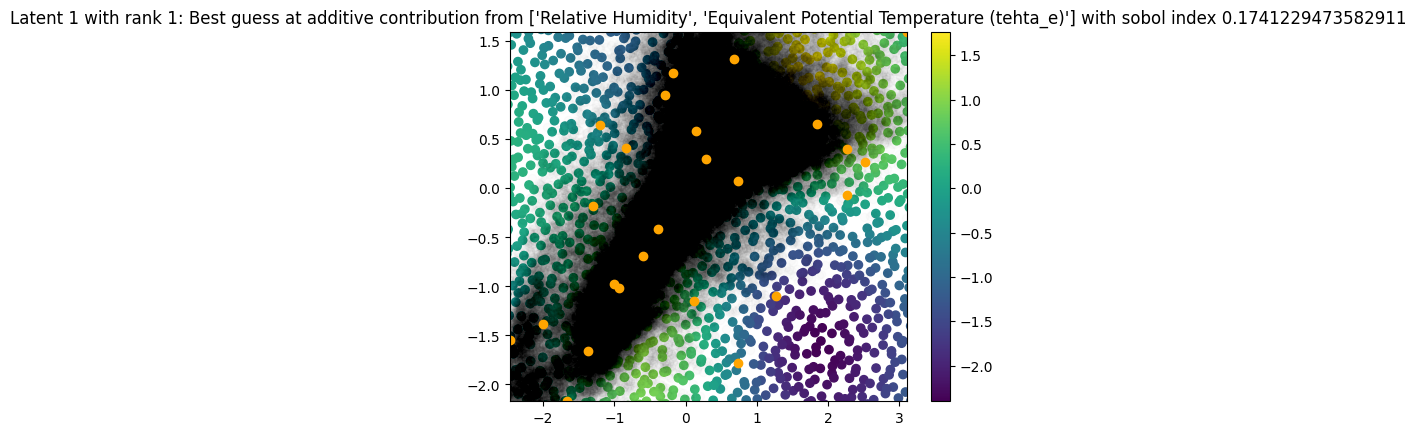

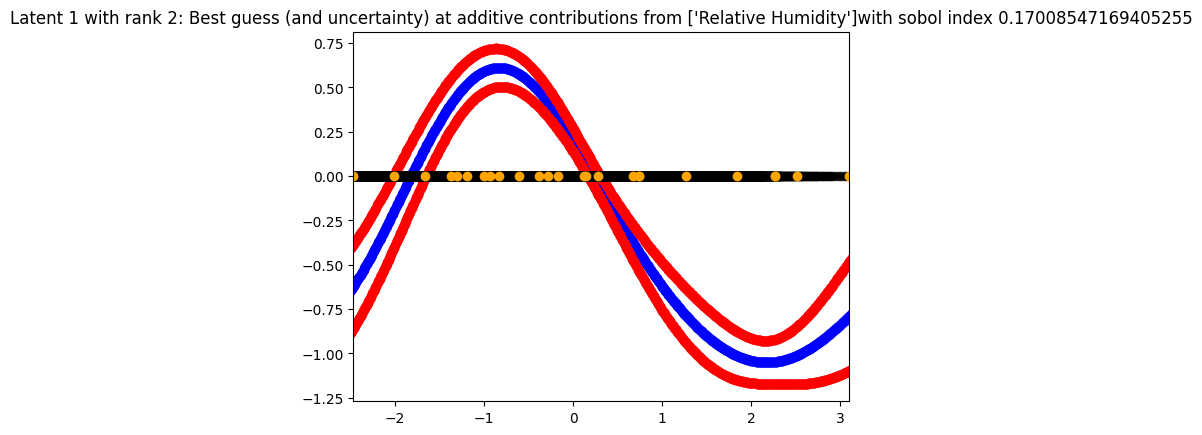

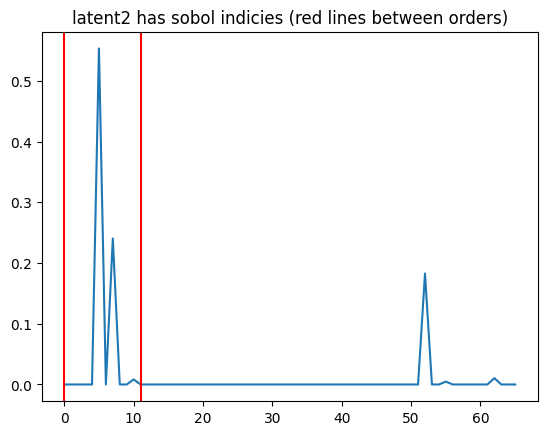

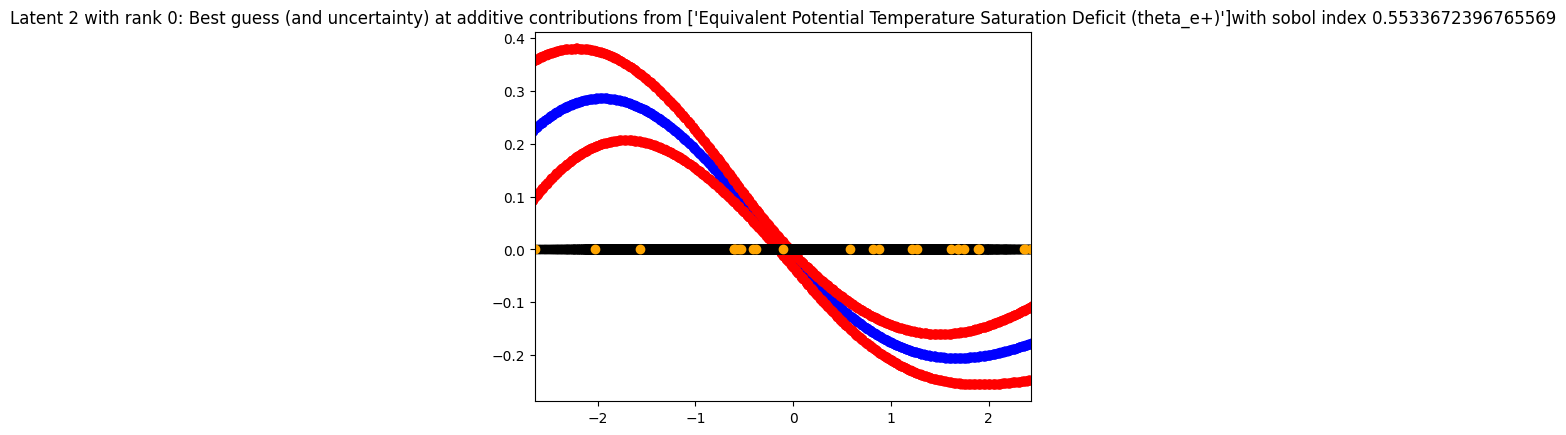

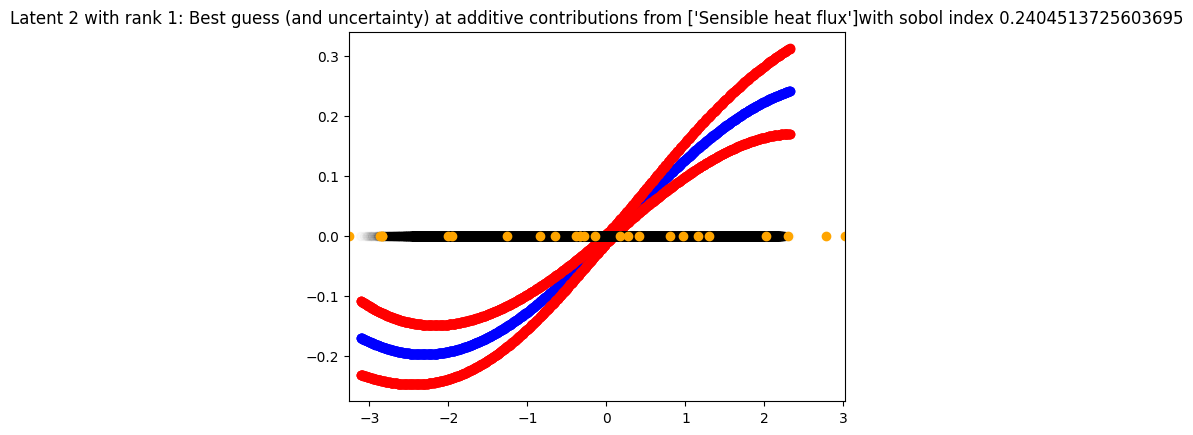

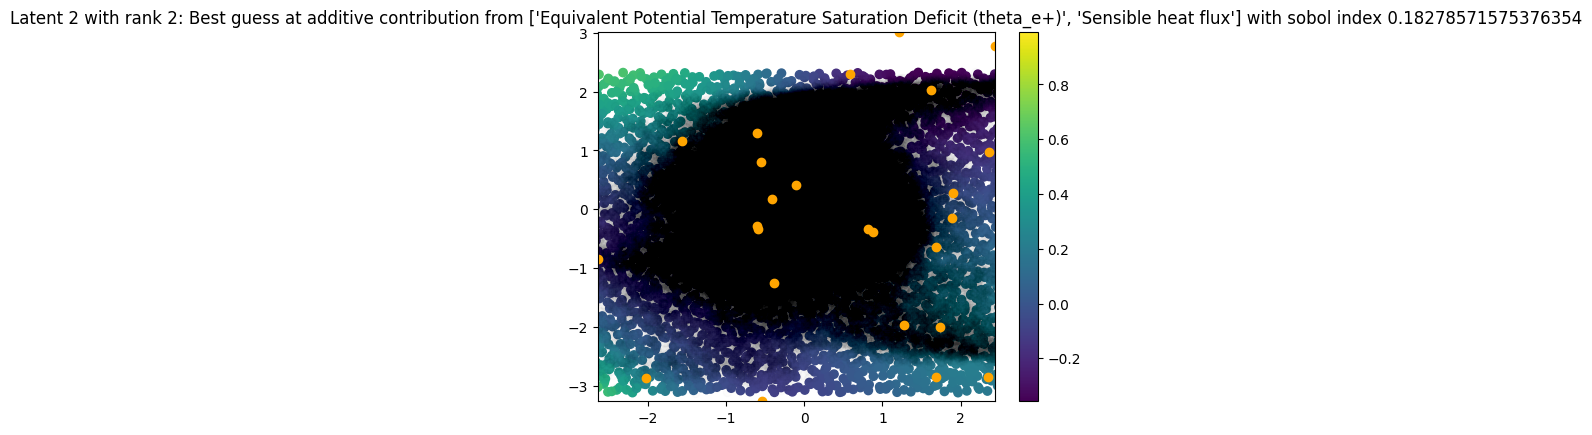

In [8]:
# plot_interactions(problem_info, thinned_model, D, use_range=False, k=3)